In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../..')

In [4]:
import pandas as pd
import deepmatcher as dm
from utils.explainer import generateExplanations

In [ ]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid2.pth')

In [ ]:
positives_nn = pd.read_csv('experiments/results/positives_nn_hybrid_withoutfilter.csv')
negatives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')

In [ ]:
selected_attributes = ['Price','Song_Name','Time']

In [ ]:
critical_forPositives = {}
for att in selected_attributes:
    critical_values = generateExplanations(positives_nn,10,0.03,negatives,att,hybrid_model,
                                         '../../Structured/itunes-amazon/positives.csv',1)
    critical_forPositives[att] = critical_values

In [ ]:
negatives_nn = pd.read_csv('experiments/results/negatives_nn_hybrid_withoutfilter.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/positives.csv')

In [ ]:
critical_forNegatives = {}
for att in selected_attributes:
    critical_values = generateExplanations(negatives_nn,10,0.03,positives,att,hybrid_model,
                                         '../../Structured/itunes-amazon/negatives.csv',0)
    critical_forNegatives[att] = critical_values

In [ ]:
for name in critical_forNegatives['Song_Name']:
    print (name.iloc[0]['ltable_Song_Name'])
    print (name.iloc[0]['rtable_Song_Name'])

## Build new samples based on critical values

### Try first with 5% of each critical

In [ ]:
train_df = pd.read_csv('../../Structured/itunes-amazon/merged_train.csv')
train_len = train_df.shape[0]

In [ ]:
newSamples_onTime = []
for df in critical_forPositives['Time']:
    if df.shape[0] < (train_len/20):
        newSamples_onTime.append(df)
    else:
        newSamples_onTime.append(df.sample(n=int(train_len/20),random_state=1))
for df in critical_forNegatives['Time']:
    if df.shape[0] < (train_len/20):
        newSamples_onTime.append(df)
    else:
        newSamples_onTime.append(df.sample(n=int(train_len/20),random_state=1))
newSamples_onTime = pd.concat(newSamples_onTime)

In [ ]:
newSamples_onPrice = []
for df in critical_forPositives['Price']:
    if df.shape[0] < (train_len/20):
        newSamples_onPrice.append(df)
    else:
        newSamples_onPrice.append(df.sample(n=int(train_len/20),random_state=1))
for df in critical_forNegatives['Price']:
    if df.shape[0] < (train_len/20):
        newSamples_onPrice.append(df)
    else:
        newSamples_onPrice.append(df.sample(n=int(train_len/20),random_state=1))
newSamples_onPrice = pd.concat(newSamples_onPrice)

In [ ]:
newSamples = pd.concat([newSamples_onTime,newSamples_onPrice])

In [ ]:
import numpy as np
newSamples = newSamples_onTime.drop(columns=['match_score'])
newSamples['id'] = np.arange(train_len,train_len+newSamples.shape[0])
newTrain = pd.concat([train_df,newSamples])

In [ ]:
newTrain.to_csv('temp/extended_train.csv',index=False)

## Train new model

In [ ]:
!cp ../../Structured/itunes-amazon/merged_valid.csv temp
!cp ../../Structured/itunes-amazon/merged_test.csv temp

In [5]:
train,validation,test = dm.data.process('temp',train='extended_train.csv',validation='merged_valid.csv',
                                       test='merged_test.csv',left_prefix='ltable_',right_prefix='rtable_')

In [6]:
train.get_raw_table()['label'].value_counts()

0    356
1    216
Name: label, dtype: int64

In [7]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.run_train(train,validation,best_save_path='temp/model.pth',batch_size=16,epochs=20)

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


Finished Epoch 1 || Run Time:    9.5 | Load Time:    1.2 || F1:  43.51 | Prec:  72.83 | Rec:  31.02 || Ex/s:  53.17

===>  EVAL Epoch 1


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 1 || Run Time:    0.6 | Load Time:    0.2 || F1:  70.00 | Prec:  63.64 | Rec:  77.78 || Ex/s: 127.88

* Best F1: 70.0
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 2 || Run Time:    8.3 | Load Time:    1.1 || F1:  82.04 | Prec:  86.22 | Rec:  78.24 || Ex/s:  60.86

===>  EVAL Epoch 2


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 2 || Run Time:    0.6 | Load Time:    0.2 || F1:  89.29 | Prec:  86.21 | Rec:  92.59 || Ex/s: 136.92

* Best F1: 89.28571428571429
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 3 || Run Time:    8.4 | Load Time:    1.1 || F1:  96.73 | Prec:  97.64 | Rec:  95.83 || Ex/s:  60.35

===>  EVAL Epoch 3


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 3 || Run Time:    0.7 | Load Time:    0.2 || F1:  92.86 | Prec:  89.66 | Rec:  96.30 || Ex/s: 124.98

* Best F1: 92.85714285714288
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 4


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 4 || Run Time:    7.8 | Load Time:    1.1 || F1:  99.30 | Prec: 100.00 | Rec:  98.61 || Ex/s:  64.41

===>  EVAL Epoch 4


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 4 || Run Time:    0.6 | Load Time:    0.2 || F1:  88.52 | Prec:  79.41 | Rec: 100.00 || Ex/s: 135.69

---------------------

===>  TRAIN Epoch 5


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 5 || Run Time:    7.9 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  63.87

===>  EVAL Epoch 5


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 5 || Run Time:    0.6 | Load Time:    0.2 || F1:  92.86 | Prec:  89.66 | Rec:  96.30 || Ex/s: 134.18

---------------------

===>  TRAIN Epoch 6


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 6 || Run Time:    7.9 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  63.96

===>  EVAL Epoch 6


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 6 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 135.73

* Best F1: 96.29629629629629
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 7


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 7 || Run Time:    7.7 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  65.26

===>  EVAL Epoch 7


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 7 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 136.06

---------------------

===>  TRAIN Epoch 8


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 8 || Run Time:    7.8 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.61

===>  EVAL Epoch 8


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 8 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 137.56

---------------------

===>  TRAIN Epoch 9


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 9 || Run Time:    7.8 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.81

===>  EVAL Epoch 9


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 9 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 133.29

---------------------

===>  TRAIN Epoch 10


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 10 || Run Time:    7.8 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.30

===>  EVAL Epoch 10


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 10 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 136.02

---------------------

===>  TRAIN Epoch 11


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 11 || Run Time:    7.8 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.49

===>  EVAL Epoch 11


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 11 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 135.30

---------------------

===>  TRAIN Epoch 12


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 12 || Run Time:    8.1 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  62.08

===>  EVAL Epoch 12


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 12 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 129.00

---------------------

===>  TRAIN Epoch 13


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 13 || Run Time:    7.6 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  65.85

===>  EVAL Epoch 13


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 13 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 137.07

---------------------

===>  TRAIN Epoch 14


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 14 || Run Time:    7.7 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.99

===>  EVAL Epoch 14


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 14 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 136.57

---------------------

===>  TRAIN Epoch 15


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 15 || Run Time:    7.7 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.88

===>  EVAL Epoch 15


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 15 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 136.29

---------------------

===>  TRAIN Epoch 16


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 16 || Run Time:    7.8 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.75

===>  EVAL Epoch 16


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 16 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 135.79

---------------------

===>  TRAIN Epoch 17


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


Finished Epoch 17 || Run Time:    7.8 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  64.63

===>  EVAL Epoch 17


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 17 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 131.48

---------------------

===>  TRAIN Epoch 18


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 18 || Run Time:    8.5 | Load Time:    1.1 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  59.32

===>  EVAL Epoch 18


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 18 || Run Time:    0.8 | Load Time:    0.3 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 101.85

---------------------

===>  TRAIN Epoch 19


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 19 || Run Time:    8.8 | Load Time:    1.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  57.12

===>  EVAL Epoch 19


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 19 || Run Time:    0.7 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 114.54

---------------------

===>  TRAIN Epoch 20


0% [███████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


Finished Epoch 20 || Run Time:    8.7 | Load Time:    1.2 || F1: 100.00 | Prec: 100.00 | Rec: 100.00 || Ex/s:  57.91

===>  EVAL Epoch 20


0% [█] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Finished Epoch 20 || Run Time:    0.6 | Load Time:    0.2 || F1:  96.30 | Prec:  96.30 | Rec:  96.30 || Ex/s: 135.50

---------------------

Loading best model...
Training done.


96.29629629629629

In [8]:
model.run_eval(test)

===>  EVAL Epoch 6
Finished Epoch 6 || Run Time:    0.4 | Load Time:    0.2 || F1:  98.11 | Prec: 100.00 | Rec:  96.30 || Ex/s: 176.97



98.11320754716981

### Recompute rankings

In [11]:
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi

In [12]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [13]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('temp/model.pth')

In [14]:
neg_classifier_hybrid,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model,
                                                                        hybrid_model.classifier,device=-1)

In [15]:
pos_classifier_hybrid,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier,device=-1)

In [16]:
hybrid_model = hybrid_model.cuda()

In [17]:
classifier_len_hybrid = len(neg_classifier_hybrid[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))

In [18]:
negatives_ri_hybrid,neg_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,neg_classifier_hybrid,attribute_len_hybrid,1)

100%|██████████| 128/128 [00:31<00:00,  5.09it/s]


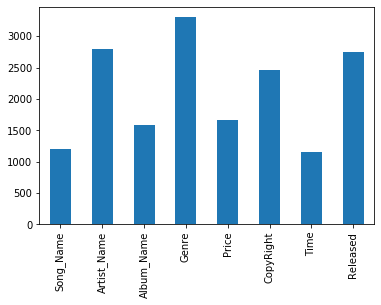

In [20]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms_hybrid,columns=attributes)
neg_variation_df.sum().plot.bar()

In [21]:
pos_ri_hybrid,pos_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,pos_classifier_hybrid,attribute_len_hybrid,0)

100%|██████████| 4/4 [00:00<00:00,  3.94it/s]


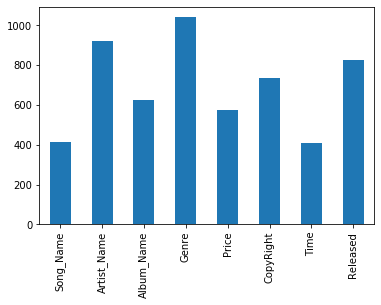

In [22]:
pos_variation_df = pd.DataFrame(data= pos_ri_norms_hybrid,columns=attributes)
pos_variation_df.sum().plot.bar()

## Test rankings meaning

In [33]:
from utils.explainer import testOscillation 

In [39]:
testOscillation(hybrid_model,'../../Structured/itunes-amazon/test_positives.csv','Time',1,'3:30|2.50')


Reading and processing data from "../../Structured/itunes-amazon/test_positives.csv"
0% [########################### ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6



Reading and processing data from "temp/new_test.csv"


Finished Epoch 6 || Run Time:    0.1 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [########################### ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6
Finished Epoch 6 || Run Time:    0.1 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(26, 27)

In [41]:
testOscillation(hybrid_model,'../../Structured/itunes-amazon/test_negatives.csv','Time',0,'3:30|3:30')


Reading and processing data from "../../Structured/itunes-amazon/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6



Reading and processing data from "temp/new_test.csv"


Finished Epoch 6 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6
Finished Epoch 6 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(82, 82)

In [47]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/itunes_amazon_hybrid2.pth')

In [51]:
testOscillation(model,'../../Structured/itunes-amazon/test_positives.csv','Time',1,'4.15|6:20')


Reading and processing data from "../../Structured/itunes-amazon/test_positives.csv"
0% [########################### ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6



Reading and processing data from "temp/new_test.csv"


Finished Epoch 6 || Run Time:    0.1 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [########################### ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6
Finished Epoch 6 || Run Time:    0.1 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(24, 20)

In [49]:
testOscillation(model,'../../Structured/itunes-amazon/test_negatives.csv','Time',0,'4:10|4:10')


Reading and processing data from "../../Structured/itunes-amazon/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6



Reading and processing data from "temp/new_test.csv"


Finished Epoch 6 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



0% [############################# ] 100% | ETA: 00:00:00

===>  PREDICT Epoch 6
Finished Epoch 6 || Run Time:    0.3 | Load Time:    0.2 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00



(79, 33)